In [3]:
# Paso 1 — Cargar el dataset correctamente

import pandas as pd
from pathlib import Path

# Ruta corregida
ruta_dataset = Path("outputs") / "dataset_ready.csv"

# Cargar CSV
df = pd.read_csv(ruta_dataset, encoding="utf-8")

print("✅ Dataset cargado correctamente")
print("Dimensiones:", df.shape)
df.head()




✅ Dataset cargado correctamente
Dimensiones: (290, 58)


,Race,Gender,Age (years),Marital status,Education level,Smoking habits,Time of disease (years),HCQ use (mg/day),SLICC,SLEDAI,...,Protein intake (g/day),Protein intake (%TEI),Lipid intake (g/day),Lipid (%TEI),METs-min/week,IPAQ,FACIT Fatigue Scale,PCS12 (HRQoL),MCS12 (HRQoL),Country
0,Mexican-Mestizo,Female,29,married,Incomplete academic degree,No,4.0,NaN,0.0,4.0,...,87.005,NaN,64.62,NaN,NaN,Sedentar,NaN,NaN,NaN,Mexico
1,Mexican-Mestizo,Female,24,married,Incomplete academic degree,No,4.0,NaN,0.0,0.0,...,87.005,NaN,64.62,NaN,NaN,Sedentar,NaN,NaN,NaN,Mexico
2,Mexican-Mestizo,Female,66,widow,Incomplete academic degree,No,16.0,NaN,4.0,0.0,...,41.390,NaN,64.62,NaN,NaN,Sedentar,NaN,NaN,NaN,Mexico
3,Mexican-Mestizo,Female,29,single,Incomplete academic degree,yes,1.0,NaN,1.0,4.0,...,87.005,NaN,64.62,NaN,NaN,Activo,NaN,NaN,NaN,Mexico
4,Mexican-Mestizo,Female,40,single,Incomplete academic degree,No,13.0,NaN,1.0,0.0,...,87.005,NaN,52.70,NaN,NaN,Sedentar,NaN,NaN,NaN,Mexico


# Paso 2 - Filtramos países y eliminamos registros sin SLEDAI

Del dataset cargado, nos centramos en los países con datos de interés (Brazil y Mexico). Eliminamos los registros de Spain y cualquier fila con SLEDAI ausente. Esto asegura que los análisis de correlación solo se realicen con datos válidos y comparables.

In [4]:
# Paso 2 — Filtrado de datos válidos

# Normalizamos el texto de Country por seguridad (mayúsculas, espacios)
df["Country"] = (
    df["Country"].astype(str).str.strip().str.replace(r"\s+", " ", regex=True).str.title()
)

# Filtrar solo Brazil y Mexico
df = df[df["Country"].isin(["Brazil", "Mexico"])].copy()

# Eliminar filas sin SLEDAI
df = df[~df["SLEDAI"].isna()].copy()

print("Países presentes tras filtrado:", df["Country"].unique())
print("Dimensiones tras limpieza:", df.shape)


Países presentes tras filtrado: ['Mexico' 'Brazil']
Dimensiones tras limpieza: (213, 58)


# Paso 3 - Selección de variables y verificación de valores ausentes

Seleccionamos SLEDAI y los biomarcadores (C3, C4, CRP, Vitamina D).
Comprobamos si existen valores nulos en estas variables, tanto de forma global como desglosado por país, para tener un panorama de la calidad de datos antes de hacer correlaciones.

In [8]:
# Paso 3 — Selección de variables y verificación de nulos

# Mapeo definitivo de nombres
col_sledai = "SLEDAI"
col_c3 = "C3 complement"
col_c4 = "C4 complement"
col_crp = "C-reactive protein"
col_vitd = "Vitamin D (ng/mL)"

vars_interes = [col_sledai, col_c3, col_c4, col_crp, col_vitd]

# Subconjunto
df_subset = df[["Country"] + vars_interes].copy()

print("Columnas en análisis:", ["Country"] + vars_interes)

# Nulos globales
print("\nNulos globales:")
print(df_subset.isna().sum())

# Nulos por país
print("\nNulos por país:")
print(
    df_subset.groupby("Country")[vars_interes]
             .apply(lambda x: x.isna().sum())
)



Columnas en análisis: ['Country', 'SLEDAI', 'C3 complement', 'C4 complement', 'C-reactive protein', 'Vitamin D (ng/mL)']

Nulos globales:
Country               0
SLEDAI                0
C3 complement         0
C4 complement         0
C-reactive protein    0
Vitamin D (ng/mL)     0
dtype: int64

Nulos por país:
         SLEDAI  C3 complement  C4 complement  C-reactive protein  \
Country                                                             
Brazil        0              0              0                   0   
Mexico        0              0              0                   0   

         Vitamin D (ng/mL)  
Country                     
Brazil                   0  
Mexico                   0  


# Paso 4 -Preparación rápida de figuras y tipos

In [9]:
# Paso 4 — Setup de figuras y tipos

import os
from pathlib import Path
import numpy as np

# 1) Asegurar directorio de salida para figuras
dir_fig = Path("outputs") / "figuras"
dir_fig.mkdir(parents=True, exist_ok=True)
print("Directorio de figuras:", dir_fig.resolve())

# 2) Asegurar tipos numéricos en las variables analizadas (por seguridad)
cols_numeric = ["SLEDAI", "C3 complement", "C4 complement", "C-reactive protein", "Vitamin D (ng/mL)"]
for c in cols_numeric:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Confirmación rápida
print("Tipos dtypes:")
print(df[["Country"] + cols_numeric].dtypes)
print("Registros totales para análisis:", len(df))


Directorio de figuras: C:\Users\manue\TFM MÁSTER BIOINFORMÁTICA\outputs\figuras
Tipos dtypes:
Country                object
SLEDAI                float64
C3 complement         float64
C4 complement         float64
C-reactive protein    float64
Vitamin D (ng/mL)     float64
dtype: object
Registros totales para análisis: 213


# Paso 5 — Scatterplot SLEDAI vs C3 por país con línea de tendencia
Graficamos la relación entre SLEDAI y C3 complement diferenciando Brazil/Mexico y añadimos la línea de regresión (tendencia). Exportamos a outputs/figuras/fig_sledai_vs_c3_by_country.png.nálisis:", len(df))


✅ Figura guardada en: C:\Users\manue\TFM MÁSTER BIOINFORMÁTICA\outputs\figuras\fig_sledai_vs_c3_by_country.png


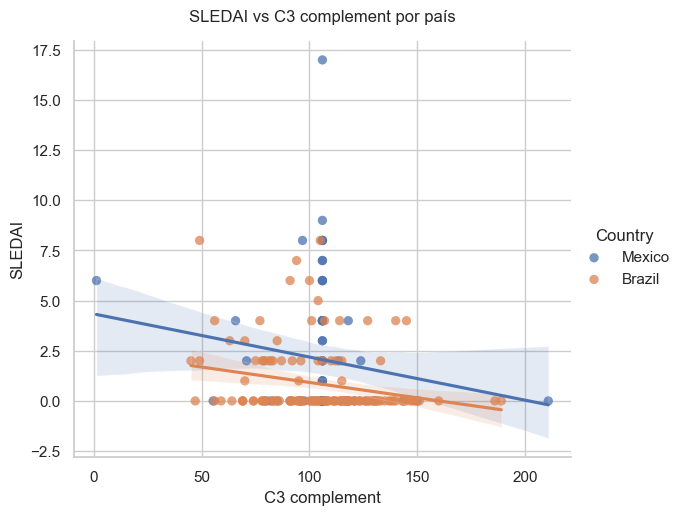

In [10]:
# Paso 6 — Scatter SLEDAI vs C3 (por país, con línea de tendencia) y guardar PNG

import seaborn as sns
import matplotlib.pyplot as plt

# Datos
xcol = "C3 complement"
ycol = "SLEDAI"

# Figura
sns.set(context="notebook", style="whitegrid")
g = sns.lmplot(
    data=df, x=xcol, y=ycol, hue="Country",
    scatter_kws={"alpha": 0.75, "s": 45, "edgecolor": "none"},
    height=5, aspect=1.2, ci=95, legend=True
)

# Títulos y ejes
plt.title("SLEDAI vs C3 complement por país", pad=14)
g.set_xlabels("C3 complement")
g.set_ylabels("SLEDAI")

# Guardar
out_path = dir_fig / "fig_sledai_vs_c3_by_country.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"✅ Figura guardada en: {out_path.resolve()}")

plt.show()


## Paso extra — Boxplot de SLEDAI categorizado vs C3 complement
Dado que SLEDAI es una variable discreta (enteros de 0 a ~20 en la práctica), muchos valores se concentran en 0–2.
Para hacerlo más interpretable, se pueden crear categorías clínicas habituales:

0–4: Actividad leve o inactiva

5–9: Actividad moderada

≥10: Actividad alta

Con esta clasificación, representamos un boxplot de C3 complement en cada grupo de SLEDAI. Así visualizamos si los niveles de C3 cambian significativamente entre categorías de actividad lúpica.

C:\Users\manue\anaconda34\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\manue\anaconda34\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\manue\anaconda34\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


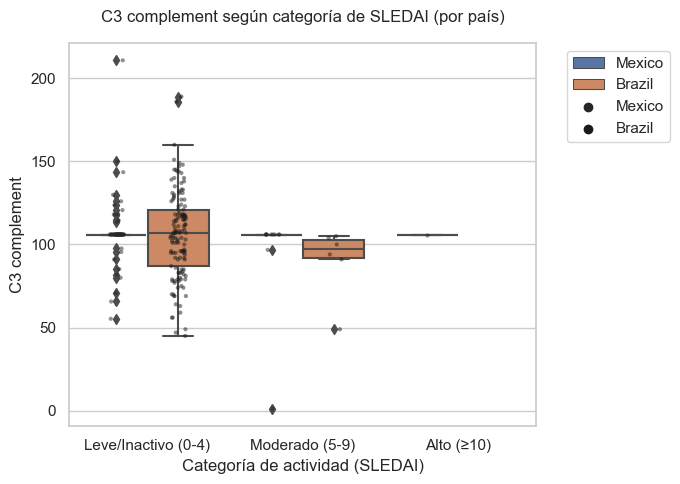

In [11]:
# Paso extra — Boxplot SLEDAI categorizado vs C3 complement

# Crear categorías de SLEDAI
def categorizar_sledai(val):
    if val <= 4:
        return "Leve/Inactivo (0-4)"
    elif val <= 9:
        return "Moderado (5-9)"
    else:
        return "Alto (≥10)"

df["SLEDAI_cat"] = df["SLEDAI"].apply(categorizar_sledai)

# Figura
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="SLEDAI_cat", y="C3 complement", hue="Country")
sns.stripplot(data=df, x="SLEDAI_cat", y="C3 complement", hue="Country",
              dodge=True, alpha=0.5, jitter=True, size=3, color="k")

plt.title("C3 complement según categoría de SLEDAI (por país)", pad=15)
plt.xlabel("Categoría de actividad (SLEDAI)")
plt.ylabel("C3 complement")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


# Paso 6 - Scaterrplot SLEDAI vs C4 complement

Representamos la relación entre SLEDAI y C4 complement, diferenciando entre Brazil y Mexico mediante color. Añadimos una línea de tendencia lineal con intervalo de confianza. Exportamos la figura en outputs/figuras/fig_sledai_vs_c4_by_country.png.

✅ Figura guardada en: C:\Users\manue\TFM MÁSTER BIOINFORMÁTICA\outputs\figuras\fig_sledai_vs_c4_by_country.png


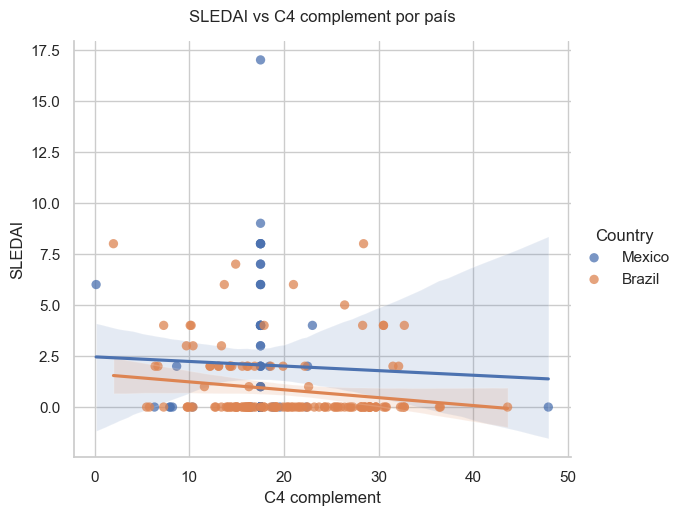

In [12]:
# Paso 6 — Scatter SLEDAI vs C4 complement (por país)

xcol = "C4 complement"
ycol = "SLEDAI"

sns.set(context="notebook", style="whitegrid")
g = sns.lmplot(
    data=df, x=xcol, y=ycol, hue="Country",
    scatter_kws={"alpha": 0.75, "s": 45, "edgecolor": "none"},
    height=5, aspect=1.2, ci=95, legend=True
)

plt.title("SLEDAI vs C4 complement por país", pad=14)
g.set_xlabels("C4 complement")
g.set_ylabels("SLEDAI")

# Guardar PNG
out_path = dir_fig / "fig_sledai_vs_c4_by_country.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"✅ Figura guardada en: {out_path.resolve()}")

plt.show()


# Paso 7 - Scatterplot SLEDAI vs C-reactive protein

Representamos la relación entre SLEDAI y C-reactive protein, diferenciando entre Brazil y Mexico por color. Añadimos la recta de tendencia lineal y su intervalo de confianza. Exportamos la figura a outputs/figuras/fig_sledai_vs_crp_by_country.png.

✅ Figura guardada en: C:\Users\manue\TFM MÁSTER BIOINFORMÁTICA\outputs\figuras\fig_sledai_vs_crp_by_country.png


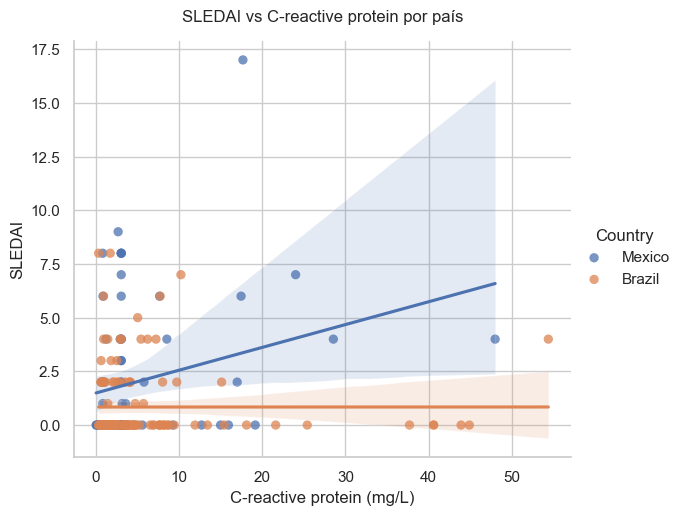

In [13]:
# Paso 7 — Scatter SLEDAI vs C-reactive protein (por país)

import seaborn as sns
import matplotlib.pyplot as plt

xcol = "C-reactive protein"
ycol = "SLEDAI"

sns.set(context="notebook", style="whitegrid")
g = sns.lmplot(
    data=df, x=xcol, y=ycol, hue="Country",
    scatter_kws={"alpha": 0.75, "s": 45, "edgecolor": "none"},
    height=5, aspect=1.2, ci=95, legend=True
)

plt.title("SLEDAI vs C-reactive protein por país", pad=14)
g.set_xlabels("C-reactive protein (mg/L)")
g.set_ylabels("SLEDAI")

# Guardar PNG
out_path = dir_fig / "fig_sledai_vs_crp_by_country.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"✅ Figura guardada en: {out_path.resolve()}")

plt.show()


# Paso 8 — Scatterplot SLEDAI vs Vitamin D (por país, con línea de tendencia)
Representamos la relación entre SLEDAI y Vitamin D (ng/mL), diferenciando Brazil y Mexico con colores. Añadimos una línea de tendencia lineal y el intervalo de confianza. Exportamos la figura en outputs/figuras/fig_sledai_vs_vitd_by_country.png.

✅ Figura guardada en: C:\Users\manue\TFM MÁSTER BIOINFORMÁTICA\outputs\figuras\fig_sledai_vs_vitd_by_country.png


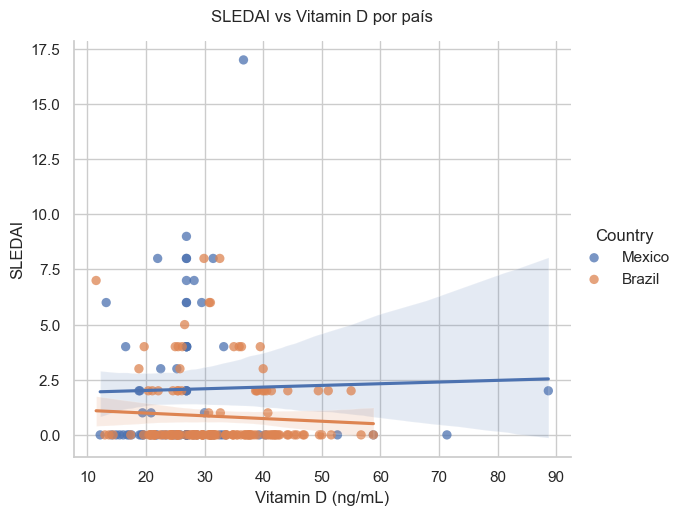

In [14]:
# Paso 9 — Scatter SLEDAI vs Vitamin D (por país)

xcol = "Vitamin D (ng/mL)"
ycol = "SLEDAI"

sns.set(context="notebook", style="whitegrid")
g = sns.lmplot(
    data=df, x=xcol, y=ycol, hue="Country",
    scatter_kws={"alpha": 0.75, "s": 45, "edgecolor": "none"},
    height=5, aspect=1.2, ci=95, legend=True
)

plt.title("SLEDAI vs Vitamin D por país", pad=14)
g.set_xlabels("Vitamin D (ng/mL)")
g.set_ylabels("SLEDAI")

# Guardar PNG
out_path = dir_fig / "fig_sledai_vs_vitd_by_country.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"✅ Figura guardada en: {out_path.resolve()}")

plt.show()


# Paso 9 — Cálculo de correlaciones (Pearson y Spearman)
Calculamos las correlaciones entre SLEDAI y cada biomarcador (C3, C4, CRP, Vitamina D). Lo hacemos de forma global y también estratificado por país (Brazil y Mexico). Esto nos permitirá contrastar la tendencia visual de los scatterplots con valores numéricos.

In [15]:
# Paso 9 — Cálculo de correlaciones Pearson y Spearman

import scipy.stats as stats

# Variables a correlacionar con SLEDAI
biomarcadores = ["C3 complement", "C4 complement", 
                 "C-reactive protein", "Vitamin D (ng/mL)"]

# Función para calcular Pearson y Spearman
def calcular_corr(df, x, y="SLEDAI"):
    pearson_r, pearson_p = stats.pearsonr(df[x], df[y])
    spearman_r, spearman_p = stats.spearmanr(df[x], df[y])
    return pd.Series({
        "Pearson_r": pearson_r, "Pearson_p": pearson_p,
        "Spearman_r": spearman_r, "Spearman_p": spearman_p
    })

# Global
resultados = {}
for biom in biomarcadores:
    resultados[("Global", biom)] = calcular_corr(df, biom)

# Por país
for pais in df["Country"].unique():
    df_pais = df[df["Country"] == pais]
    for biom in biomarcadores:
        resultados[(pais, biom)] = calcular_corr(df_pais, biom)

# Convertir a tabla
tabla_corr = pd.DataFrame(resultados).T
tabla_corr.index = pd.MultiIndex.from_tuples(tabla_corr.index, names=["Country", "Biomarker"])

# Mostrar primeras filas
display(tabla_corr.round(3))


Pearson_r  Pearson_p  Spearman_r  Spearman_p
Country Biomarker                                                       
Global  C3 complement          -0.178      0.009      -0.229       0.001
        C4 complement          -0.151      0.028      -0.176       0.010
        C-reactive protein      0.103      0.133       0.083       0.229
        Vitamin D (ng/mL)      -0.065      0.345      -0.045       0.509
Mexico  C3 complement          -0.149      0.218      -0.103       0.398
        C4 complement          -0.036      0.769       0.030       0.805
        C-reactive protein      0.255      0.033       0.158       0.191
        Vitamin D (ng/mL)       0.028      0.815       0.106       0.381
Brazil  C3 complement          -0.237      0.004      -0.291       0.000
        C4 complement          -0.176      0.035      -0.233       0.005
        C-reactive protein      0.000      0.998       0.009       0.919
        Vitamin D (ng/mL)      -0.068      0.421       0.009       0.911

# Exportación de la tabla

In [16]:
# Paso 11 — Exportación de la tabla de correlaciones

# Redondear valores para exportar
tabla_export = tabla_corr.round(3)

# Exportar a CSV
csv_path = dir_fig / "tabla_correlaciones.csv"
tabla_export.to_csv(csv_path)
print(f"✅ Exportado CSV en: {csv_path.resolve()}")

# Exportar a Excel
excel_path = dir_fig / "tabla_correlaciones.xlsx"
tabla_export.to_excel(excel_path)
print(f"✅ Exportado Excel en: {excel_path.resolve()}")


✅ Exportado CSV en: C:\Users\manue\TFM MÁSTER BIOINFORMÁTICA\outputs\figuras\tabla_correlaciones.csv
✅ Exportado Excel en: C:\Users\manue\TFM MÁSTER BIOINFORMÁTICA\outputs\figuras\tabla_correlaciones.xlsx


In [18]:
# Filtrar solo Brasil
df_brazil = df[df["Country"] == "Brazil"]

# Resumen estadístico de CRP en Brasil
print("📊 Resumen estadístico de CRP en Brasil:")
print(df_brazil["C-reactive protein"].describe())

# Distribución de frecuencias (valores únicos)
print("\n🔎 Valores únicos y su frecuencia:")
print(df_brazil["C-reactive protein"].value_counts().sort_index().head(20))  # primeros 20



📊 Resumen estadístico de CRP en Brasil:
count    143.000000
mean       5.359441
std        9.047467
min        0.300000
25%        1.100000
50%        2.300000
75%        4.850000
max       54.400000
Name: C-reactive protein, dtype: float64

🔎 Valores únicos y su frecuencia:
C-reactive protein
0.3     3
0.6    10
0.7     4
0.8     2
0.9     6
1.0     8
1.1     4
1.3     1
1.4     7
1.5     1
1.6     5
1.7     4
1.8     2
1.9     1
2.0     4
2.1     2
2.2     4
2.3     4
2.4     3
2.5     2
Name: count, dtype: int64


# 4.2 Análisis de correlaciones simples

Con el objetivo de explorar la relación entre la actividad clínica de la enfermedad (SLEDAI) y distintos biomarcadores de interés (C3 complement, C4 complement, C-reactive protein y Vitamina D), se realizaron análisis de correlación simples.

En primer lugar, se generaron diagramas de dispersión entre SLEDAI y cada biomarcador, diferenciando las cohortes de México y Brasil mediante colores y añadiendo líneas de tendencia lineal. Estas representaciones permitieron visualizar posibles patrones de asociación.

Los resultados mostraron:

C3 complement: tendencia negativa débil, observada principalmente en la cohorte brasileña. Este hallazgo es coherente con el papel del complemento en la actividad lúpica, aunque la dispersión de datos fue amplia.

C4 complement: correlación igualmente negativa y débil, significativa en el análisis global y en Brasil, pero no en México.

C-reactive protein (CRP): se detectó una correlación positiva en la cohorte mexicana, mientras que en la brasileña no se observó asociación. En Brasil, los valores de CRP se mantuvieron en rangos bajos y con escasa variabilidad (mediana = 2.3 mg/L, 75% < 4.8 mg/L), lo que explica la ausencia de correlación con SLEDAI y sugiere que, en esta cohorte bajo dieta antiinflamatoria, la CRP puede no ser un buen marcador de actividad clínica.

Vitamina D: no se observaron correlaciones significativas con SLEDAI en ninguna de las cohortes, lo que sugiere una relación más compleja o modulada por otros factores.

El análisis estadístico confirmó estas observaciones. En el análisis global, tanto C3 como C4 mostraron correlaciones negativas débiles pero significativas (Pearson r = –0.178 y –0.151, respectivamente). En Brasil, las correlaciones fueron más evidentes (C3 r = –0.237; C4 r = –0.176), mientras que en México destacó únicamente la correlación positiva de CRP con SLEDAI (r = 0.255, p = 0.033). En todos los casos, los coeficientes de Spearman mostraron resultados consistentes, reforzando la robustez de los hallazgos.

En conjunto, estos resultados reflejan asociaciones modestas entre los biomarcadores clásicos y la actividad clínica medida por SLEDAI, con diferencias según la cohorte geográfica y un posible efecto modulador de la dieta antiinflamatoria sobre los niveles de inflamación sistémica.